In [1]:
!nvidia-smi

Wed Jun 16 15:57:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Clone repo**

In [2]:
!git clone https://github.com/kaylode/vnm-ocr-toolbox/ main
%cd main

Cloning into 'main'...
remote: Enumerating objects: 1068, done.
remote: Counting objects: 100% (1068/1068), done.
remote: Compressing objects: 100% (719/719), done.
remote: Total 1068 (delta 517), reused 835 (delta 303), pack-reused 0
Receiving objects: 100% (1068/1068), 4.42 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (517/517), done.
/content/main


In [9]:
!git checkout master
!git reset --hard HEAD
!git pull

Already on 'master'
Your branch is up to date with 'origin/master'.
HEAD is now at a3a092a add prepare dataset
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 18 (delta 9), reused 18 (delta 9), pack-reused 0
Unpacking objects: 100% (18/18), done.
From https://github.com/kaylode/vnm-ocr-toolbox
   a3a092a..e967612  master     -> origin/master
Updating a3a092a..e967612
Fast-forward
 dataset/prepare.py                                 |    6 +-
 demo/[vnm_ocr_toolbox]_Inference.ipynb             | 1014 ++++++++++++
 ...ocr_toolbox]_Train_PAN_for_Text_Detection.ipynb | 1747 ++++++++++++++++++++
 modules/ocr/loader/dataloader.py                   |    6 +-
 modules/ocr/loader/dataloader_v1.py                |    4 +-
 modules/ocr/model/trainer.py                       |   20 +-
 6 files changed, 2779 insertions(+), 18 deletions(-)
 create mode 100644 demo/[vnm_ocr_toolbox]_Inference.ipynb
 creat

In [4]:
%%capture
!pip install -r requirements.txt --upgrade # --force-reinstall

# **Prepare data for OCR**

In [5]:
%cd /content/main
!mkdir data

/content/main


In [6]:
%cd /content/main/data

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1bckFiNBMcr2BH1zCJl-MhV9l1AlAmtlQ',
                                    dest_path='./mcocr.zip',
                                    unzip=True)

/content/main/data
Unzipping...Done.


In [1]:
%cd /content/main
from dataset.prepare import extract_mcocr, split_mcocr

/content/main


In [2]:
extract_mcocr("/content/main/data/mcocr_public/mcocr_train_data/", "/content/main/data/ocr_data")
split_mcocr("/content/main/data/ocr_data")

100%|██████████| 1155/1155 [00:17<00:00, 64.68it/s]


#**Training**

In [1]:
%cd /content/main
from tool.config import Config
from modules.ocr.tool.config import Cfg
from modules.ocr.model.trainer import Trainer

/content/main


In [2]:
# Load model config
config = Config("tool/config/ocr/configs.yaml")

# Set model configs
model_config = Cfg.load_config_from_name(config.model_name)

# Dataset params
dataset_params = {
    "name": config.project_name,
    "data_root": config.data_root,
    "train_annotation": config.train_annotation,
    "valid_annotation": config.valid_annotation,
    "export": config.data_export
}

# Training params
params = {
    "print_every": config.print_every,
    "valid_every": config.valid_every,
    "iters": config.iters,
    "export": config.export
}

model_config["trainer"].update(params)
model_config["dataset"].update(dataset_params)
model_config["device"] = config.gpu_devices

In [3]:
# Start training
trainer = Trainer(model_config, pretrained=True)
trainer.train()

Computing MD5: /tmp/tranformerorc.pth


Create ./data/train_mcocr:   0%|                                           | 0/5927 [00:00<?, ?it/s]

MD5 matches: /tmp/tranformerorc.pth


Create ./data/train_mcocr: 100%|██████████████████████████████| 5927/5927 [00:01<00:00, 3223.09it/s]


Created dataset with 5926 samples


./data/train_mcocr build cluster: 100%|██████████████████████| 5926/5926 [00:00<00:00, 98872.84it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Create ./data/valid_mcocr: 100%|████████████████████████████████| 658/658 [00:00<00:00, 5849.76it/s]


Created dataset with 657 samples


./data/valid_mcocr build cluster: 100%|████████████████████████| 657/657 [00:00<00:00, 43158.30it/s]


KeyboardInterrupt: ignored

#**Inference**


In [6]:
import matplotlib.pyplot as plt
from PIL import Image

from modules.ocr.tool.predictor import Predictor
from modules.ocr.tool.config import Cfg

In [7]:
model_config = Cfg.load_config_from_name(config.model_name)

In [8]:
model_config['weights'] = '/content/main/weights/transformerocr.pth'

In [9]:
model_config['cnn']['pretrained']=False
model_config['device'] = 'cuda:0'
model_config['predictor']['beamsearch']=False

In [10]:
detector = Predictor(model_config)

'Phuong Dong Hoa, Thi xa Di An, Tinh Binh Duong'

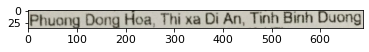

In [11]:
img = '/content/main/data/ocr_data/img/00800.jpg'
img = Image.open(img)
plt.imshow(img)
s = detector.predict(img)
s